In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [50]:
from utils.harmonic_dense_block import hardnet
from utils.attention_block import Attention_block
encoder = hardnet()

68 LOADED


Using cache found in C:\Users\BMILAB/.cache\torch\hub\PingoLH_Pytorch-HarDNet_master


ImageNet pretrained weights for HarDNet68 is loaded
68 LOADED READY


In [51]:
# HDB, 需要拉出來做attention
fake_img = torch.rand(1, 3, 512,512)
hdb_outs = encoder(fake_img) # 1, 4, 9 ,12 15 conv layer output
for i in hdb_outs:
    print(i.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 128, 128])
torch.Size([1, 320, 64, 64])
torch.Size([1, 640, 32, 32])
torch.Size([1, 1024, 16, 16])


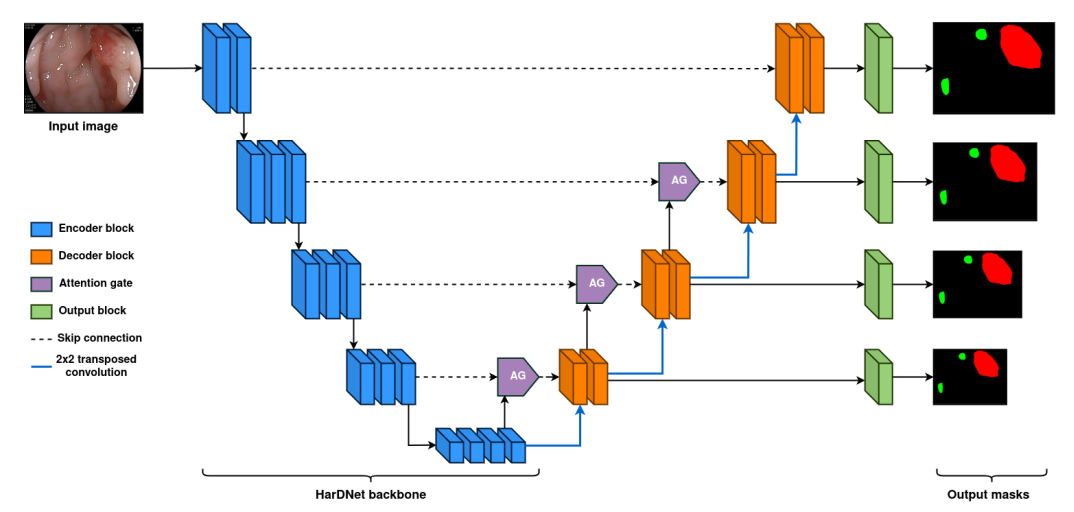

In [52]:
class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True), ############# 圖上藍線需要conv?
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)

class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()
        # 2次convolution
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class conv_1x1(nn.Module):
    def __init__(self, ch_in):
        super(conv_1x1, self).__init__()
        self.conv = nn.Conv2d(ch_in, 2, kernel_size=1, stride=1, padding=0, bias=True) # output 2個維度
        
    def forward(self, x):
        return self.conv(x)

In [53]:
class NeoUnet(nn.Module):
    def __init__(self):
        super(NeoUnet, self).__init__()
        dims = [3, 64, 128, 320, 640, 1024]
        self.encoder = hardnet()
        
        # F_g, F_l, F_int(可自己設定?)
        self.ag_L2 = Attention_block(dims[3], dims[2], dims[2]) # 320+320
        self.ag_L3 = Attention_block(dims[4], dims[3], dims[3]) # 640+640
        self.ag_L4 = Attention_block(dims[5], dims[4], dims[4]) # 1024+1024

        self.up_5to4 = up_conv(dims[5], dims[4]) # 1024 => 640
        self.up_4to3 = up_conv(dims[4], dims[3]) # 640 => 320
        self.up_3to2 = up_conv(dims[3], dims[2]) # 320 => 128
        self.up_2to1 = up_conv(dims[2], dims[1]) # 128 => 64

        self.conv_L4 = conv_block(dims[4]*2, dims[4]) ################### 第二個參數?
        self.conv_L3 = conv_block(dims[3]*2, dims[3])
        self.conv_L2 = conv_block(dims[2]*2, dims[2])
        self.conv_L1 = conv_block(dims[1]*2, dims[1])

        self.out_L4 = conv_1x1(dims[4]) # out = 2dim
        self.out_L3 = conv_1x1(dims[3])
        self.out_L2 = conv_1x1(dims[2])
        self.out_L1 = conv_1x1(dims[1])
    
    def forward(self, x):
        hdb_outs = self.encoder(x) # 1 4 9 12 15 conv layer output
        
        x4 = self.ag_L4(hdb_outs[5], hdb_outs[4]) # (640,32,32)
        g4 = self.up_5to4(hdb_outs[5]) # (1024,16,16) => (640,32,32)
        cat4 = torch.cat((x4,g4), dim=1) # (640*2,32,32), #########cat誰先後#############
        conv4 = self.conv_L4(cat4) # (640,32,32)
        out4 = self.out_L4(conv4)

        x3 = self.ag_L3(conv4, hdb_outs[3])
        g3 = self.up_4to3(conv4)
        cat3 = torch.cat((x3,g3), dim=1)
        conv3 = self.conv_L3(cat3)
        out3 = self.out_L3(conv3)

        x2 = self.ag_L2(conv3, hdb_outs[2])
        g2 = self.up_3to2(conv3)
        cat2 = torch.cat((x2,g2), dim=1)
        conv2 = self.conv_L2(cat2)
        out2 = self.out_L2(conv2)

        x1 = hdb_outs[1]
        g1 = self.up_2to1(conv2)
        cat1 = torch.cat((x1,g1), dim=1)
        conv1 = self.conv_L1(cat1)
        out1 = self.out_L1(conv1)
        return out1, out2, out3, out4

In [54]:
model = NeoUnet()
a = torch.rand(1,3,512,512)
outs = model(a)
for out in outs:
    print(out.size())

68 LOADED


Using cache found in C:\Users\BMILAB/.cache\torch\hub\PingoLH_Pytorch-HarDNet_master


ImageNet pretrained weights for HarDNet68 is loaded
68 LOADED READY
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 128, 128])
torch.Size([1, 2, 64, 64])
torch.Size([1, 2, 32, 32])


In [55]:
# d4 = torch.cat((torch.rand(1,640,32,32),torch.rand(1,640,32,32)), dim=1)
# print(d4.size())
# a = conv_block(1280, 640)
# a(d4).size()

torch.Size([1, 1280, 32, 32])


torch.Size([1, 640, 32, 32])

In [56]:
# test
# import torch
# from utils.attention_block import Attention_block
# g = torch.rand(1, 1024, 16, 16) # 高維小圖
# x = torch.rand(1, 640, 32, 32) # 低維大圖

# att = Attention_block(1024,640,128) # f_int可以隨便調?
# att(g,x).size()

torch.Size([1, 640, 32, 32])